In [10]:
from tsl.datasets import AirQuality
from tsl.datasets.mts_benchmarks import ExchangeBenchmark
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
import pandas as pd
import numpy as np
from GT import get_dataset


dataset1 = get_dataset('Synth')[0]
dataset1 = dataset1.reshape(dataset1.shape[0]*dataset1.shape[1], dataset1.shape[2])

dataset2 = ExchangeBenchmark().dataframe().values[:7560]
dataset2 = get_dataset('ExchangeBenchmark', dataset2, 216)[0]
dataset2 = dataset2.reshape(dataset2.shape[0]*dataset2.shape[1], dataset2.shape[2])

dataset3 = AirQuality(impute_nans=True, small=True).dataframe().values[:8736]
dataset3 = get_dataset('AirQuality', dataset3, 168)[0]
dataset3 = dataset3.reshape(dataset3.shape[0]*dataset3.shape[1], dataset3.shape[2])

df1 = pd.DataFrame(dataset1)
df2 = pd.DataFrame(dataset2)
df3 = pd.DataFrame(dataset3)

Synth DATA
Original Dataset: 	156
Train Split: 		52 	(70%)
Validation Split: 	52 	(20%)
Test Split: 		52 	(10%)
ExchangeBenchmark DATA
Original Dataset: 	105
Train Split: 		35 	(70%)
Validation Split: 	35 	(20%)
Test Split: 		35 	(10%)
AirQuality DATA
Original Dataset: 	156
Train Split: 		52 	(70%)
Validation Split: 	52 	(20%)
Test Split: 		52 	(10%)


In [11]:

def plot_dist(name, dataset):
    legend = False
    if dataset.shape[1] < 10:
        legend = True
    # Create a figure with 4 subplots
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharey=False, sharex=False)
    
    # Set a title for the entire figure
    fig.suptitle(f"Distribution Plots of {name} Dataset", fontsize=16)
    
    data = dataset
    # Plot KDE, boxplot, ECDF, and histogram with density for each feature
    sns.kdeplot(data, ax=ax[0, 0], palette='Paired', fill=True, legend=legend)
    ax[0, 0].set_title("Kernel Density Estimate")

    sns.boxplot(data, ax=ax[0, 1], palette='Paired', legend=False)
    ax[0, 1].set_title("Box Plot")

    sns.ecdfplot(data, ax=ax[1, 0], palette='Paired', legend=legend)
    ax[1, 0].set_title("Empirical CDF Plot")

    sns.histplot(data, ax=ax[1, 1], palette='Paired', kde=True, stat="density", alpha=0.2, legend=False)
    # sns.distplot(data, ax=ax[1, 1], color="o")
    ax[1, 1].set_title("Histogram with KDE")

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include suptitle
    plt.savefig(f'./PNG/{name}/Distribution.png')

## Datasets Distributions

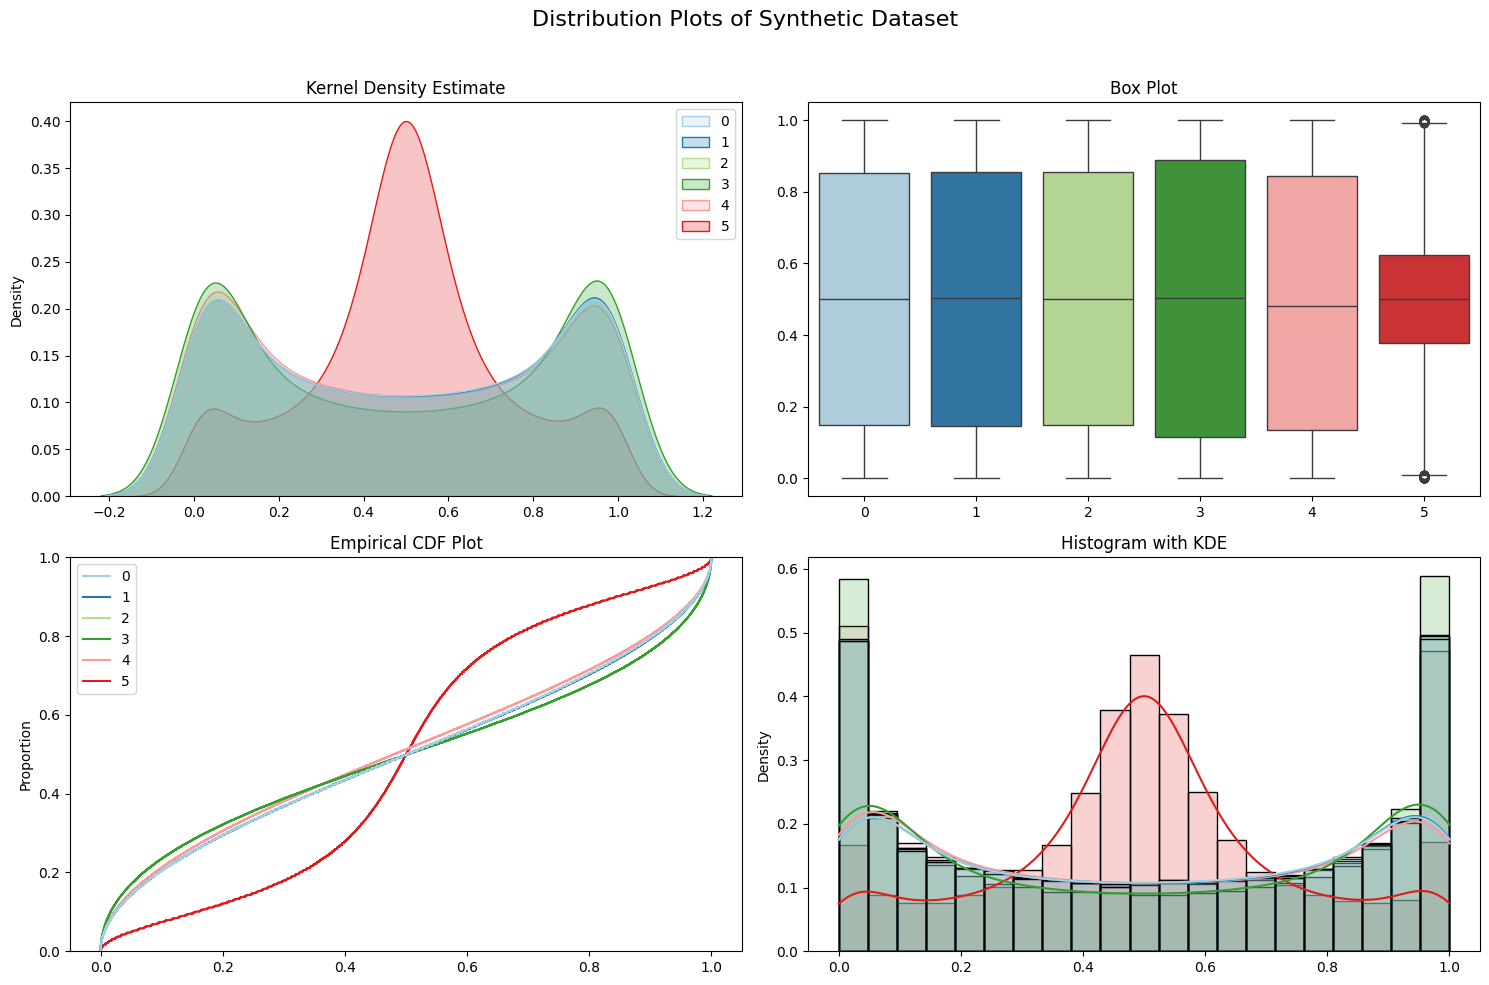

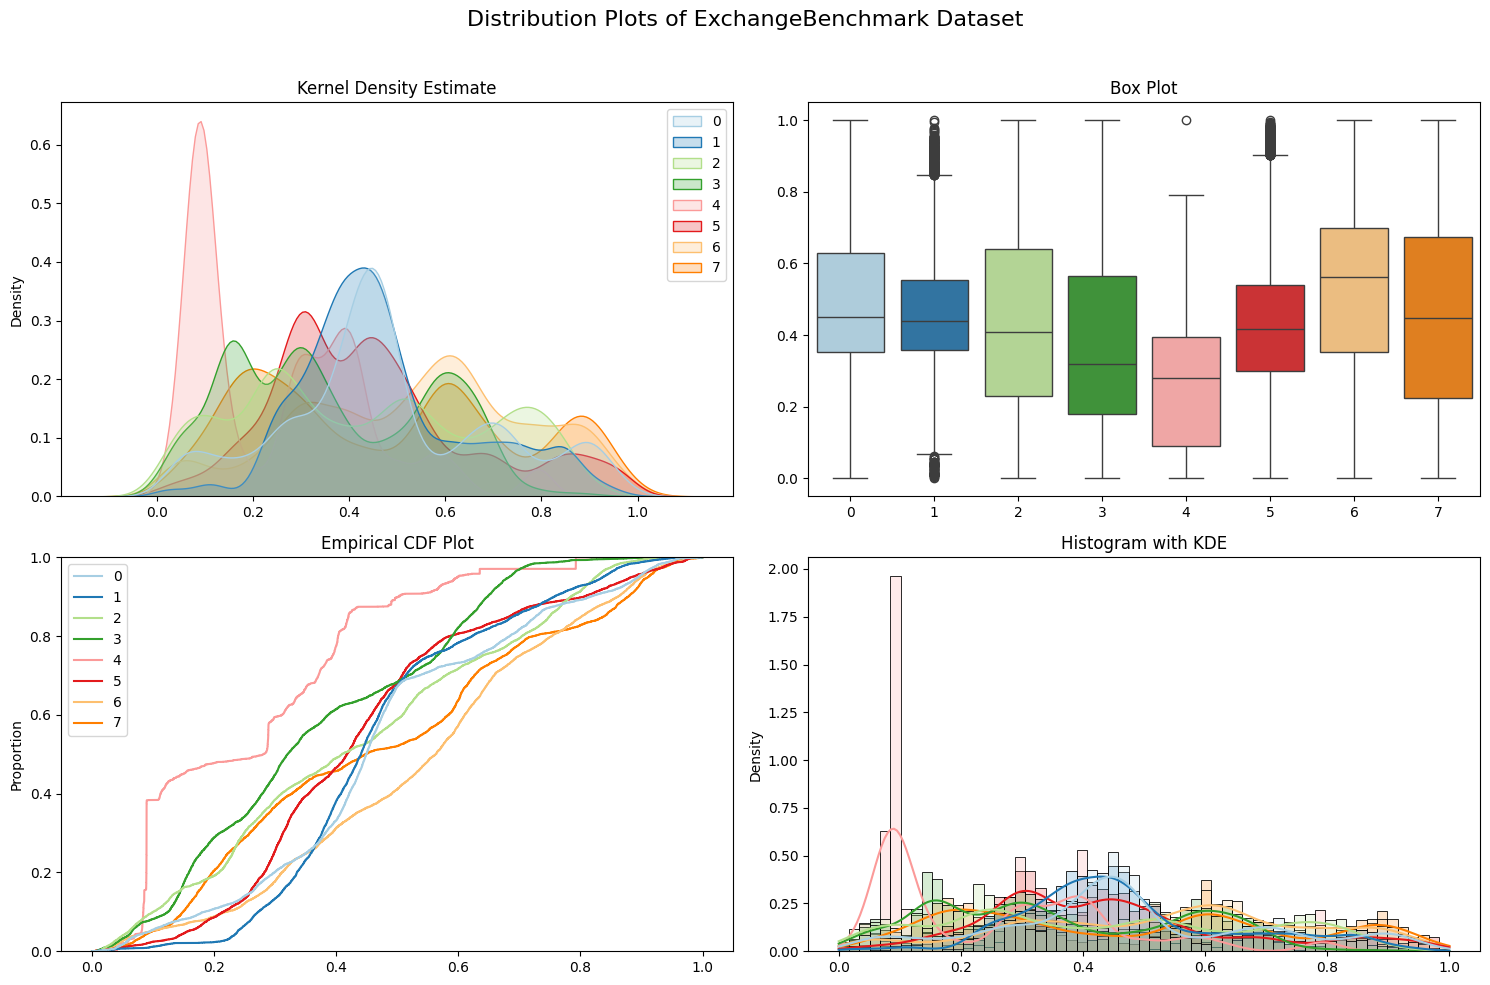

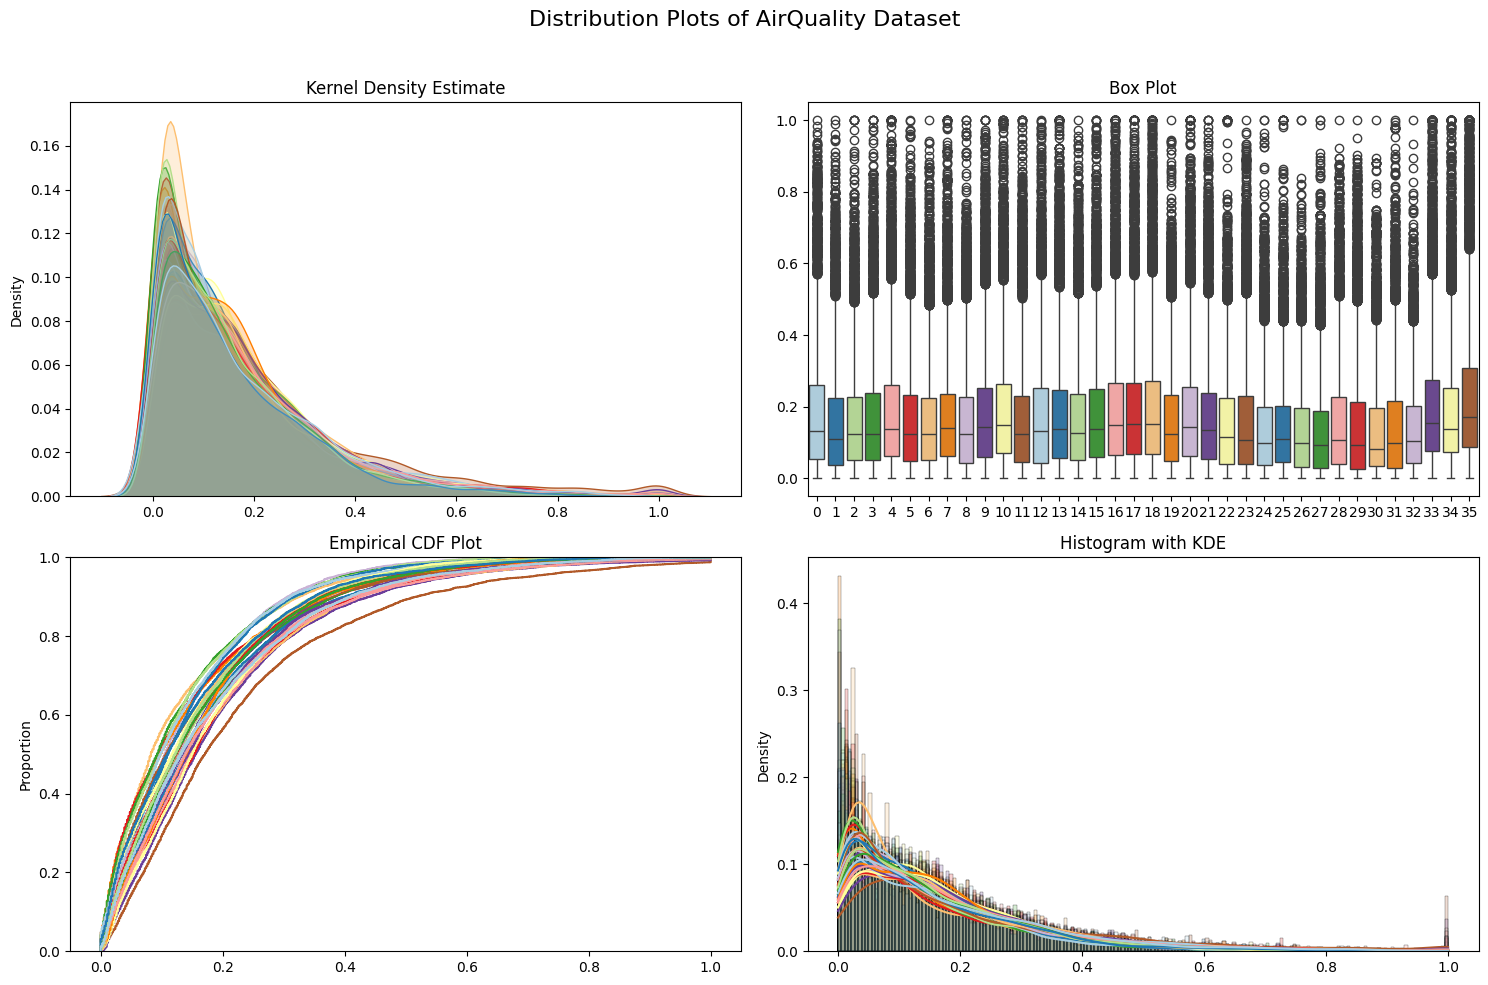

In [12]:
plot_dist('Synthetic', dataset1)
plot_dist('ExchangeBenchmark', dataset2)
plot_dist('AirQuality', dataset3)

In [24]:
def get_stats(df):
    """
    Get statistics of dataframe.
    """
    df_described = df.describe()
    stats = pd.DataFrame({'skewness': [], 'kurtosis': []})
    for column in df.columns:
        stats = pd.concat([stats, pd.DataFrame({
            'skewness': [skew(df[column])],
            'kurtosis': [kurtosis(df[column])]
        })], ignore_index=True)
    stats = stats.T
    stats.columns = df_described.columns
    df_described = pd.concat([df_described, stats], axis=0)
    return df_described.mean(axis=1)

def get_split_stats(df, dataset_name, num_splits=4):
    """
    Split the dataset into `num_splits` parts and get statistics for each.
    """
    split_size = len(df) // num_splits
    results = []
    
    for i in range(num_splits):
        # Define start and end indices for each split
        start = i * split_size
        end = (i + 1) * split_size if i < num_splits - 1 else len(df)
        
        # Get statistics for the current split
        split_stats = get_stats(df.iloc[start:end])
        split_stats['count'] = end - start  # Update count for each split
        split_stats.name = f"{dataset_name}_{i+1}"
        
        # Append to results
        results.append(split_stats)
    
    return pd.DataFrame(results)

# Get split statistics for each dataset
df1_stats = get_split_stats(df1, 'Synthetic', num_splits=4)
df2_stats = get_split_stats(df2, 'ExchangeBenchmark', num_splits=4)
df3_stats = get_split_stats(df3, 'AirQuality(36)', num_splits=4)

# Concatenate all results
df_stats = pd.concat([df1_stats, df2_stats, df3_stats], axis=0)

# Add Dataset column and reformat the table
df_stats.insert(0, 'Dataset', df_stats.index)
df_stats.reset_index(drop=True, inplace=True)

# Drop unnecessary columns and save to CSV
df_stats.drop(columns=['min', '25%', '50%', '75%', 'max'], inplace=True)
df_stats['count'] = df_stats['count'].astype('int')  # Ensure count is integer
df_stats.to_csv('datasets_statistics.csv', index=False)

In [25]:
df_stats

,Dataset,count,mean,std,skewness,kurtosis
0,Synthetic_1,819,0.499111,0.337276,0.003912,-1.286541
1,Synthetic_2,819,0.499178,0.337287,0.003157,-1.288066
2,Synthetic_3,819,0.499198,0.337299,0.003326,-1.289446
3,Synthetic_4,819,0.499158,0.337338,0.005146,-1.288531
4,ExchangeBenchmark_1,1890,0.374521,0.148728,0.233309,-0.870846
5,ExchangeBenchmark_2,1890,0.238695,0.109656,1.713830,65.278404
6,ExchangeBenchmark_3,1890,0.517283,0.153858,0.038060,-0.805193
7,ExchangeBenchmark_4,1890,0.594956,0.140047,0.145249,4.889068
8,AirQuality(36)_1,2184,0.136616,0.107031,1.129914,1.017431
9,AirQuality(36)_2,2184,0.168598,0.147468,1.678810,3.467387


# Check distribution drift for both datasets

In [15]:

def detect_drift(data, threshold=0.05):
  """
  Code for detecting data drift

  Args:
      data: sample NumPy array of data points.
      threshold: Proportion of data points allowed to fall outside the expected range (default: 0.05).

  Returns:
      A boolean indicating if data drift is detected.
  """
  mean = np.mean(data)
  std = np.std(data)
  expected_upper_bound = mean + 2 * std
  expected_lower_bound = mean - 2 * std

  # Calculate the cumulative sum of deviations from the mean
  deviations = np.cumsum(data - mean)

  # Identify data points exceeding the expected bounds
  outliers = np.sum(deviations > expected_upper_bound) + np.sum(deviations < expected_lower_bound)

  # Check if the proportion of outliers exceeds the threshold
  return outliers / len(data) > threshold


# Calculate drift for both datasets
drift_detected_1 = detect_drift(df1)
drift_detected_2 = detect_drift(df2)
drift_detected_3 = detect_drift(df3)

if np.mean(drift_detected_1):
  print("Data drift detected in Synthetic data")
else:
  print("No data drift detected in Synthetic data.")
  
if np.mean(drift_detected_2):
  print("Data drift detected in Exchange dataset")
else:
  print("No data drift detected in Exchange data.")
  
if np.mean(drift_detected_3):
  print("Data drift detected in AirQuality dataset")
else:
  print("No data drift detected in AirQuality data.")


# Check drift distribution after half dataset fit with nannyml 

## Synthetic


In [16]:
Synthetic_middle_index = len(df1) // 2

Synthetic_first_half_df = df1.iloc[:Synthetic_middle_index] # reference dataset 
Synthetic_second_half_df = df1.iloc[Synthetic_middle_index:]
Synthetic_feature_names = df1.columns
Synthetic_reference_set = Synthetic_first_half_df.copy()  
Synthetic_analysis_set = Synthetic_second_half_df.copy() 

In [17]:
from nannyml.plots.blueprints.metrics import plot_metric
Synthetic_drift_detector = nml.DataReconstructionDriftCalculator(
    column_names=Synthetic_feature_names,
    chunk_size=100
).fit(reference_data=Synthetic_reference_set)

# Calculate drift results
Synthetic_drift_results = Synthetic_drift_detector.calculate(data=Synthetic_analysis_set)

# Visualize drift
Synthetic_drift_results_plot = plot_metric(Synthetic_drift_results, title='', metric_display_name='Reconstruction Error',
                metric_column_name='reconstruction_error')
Synthetic_drift_results_plot.write_image('./PNG/Synthetic/Synthetic_drift_results.png', width=1000, height=500)
Synthetic_drift_results_plot.show()

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


## ExchangeBenchmark

In [ ]:
ExchangeBenchmark_middle_index = len(df2) // 2

ExchangeBenchmark_first_half_df = df2.iloc[:ExchangeBenchmark_middle_index] # reference dataset 
ExchangeBenchmark_second_half_df = df2.iloc[ExchangeBenchmark_middle_index:]

ExchangeBenchmark_feature_names = df2.columns
ExchangeBenchmark_reference_set = ExchangeBenchmark_first_half_df.copy()  
ExchangeBenchmark_analysis_set = ExchangeBenchmark_second_half_df.copy() 

In [19]:
ExchangeBenchmark_drift_detector = nml.DataReconstructionDriftCalculator(
    column_names=ExchangeBenchmark_feature_names,
    chunk_size=216
).fit(reference_data=ExchangeBenchmark_reference_set)

# Calculate drift results
ExchangeBenchmark_drift_results = ExchangeBenchmark_drift_detector.calculate(data=ExchangeBenchmark_analysis_set)

# Visualize drift
ExchangeBenchmark_drift_results_plot = plot_metric(ExchangeBenchmark_drift_results, title='', metric_display_name='Reconstruction Error',
                metric_column_name='reconstruction_error')
# PemsBay_drift_results_plot = PemsBay_drift_results.plot()
ExchangeBenchmark_drift_results_plot.write_image('./PNG/ExchangeBenchmark/ExchangeBenchmark_drift_results.png', width=1000, height=500)
ExchangeBenchmark_drift_results_plot.show()

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.



## AirQuality

In [20]:
AirQuality_middle_index = len(df3) // 2

AirQuality_first_half_df = df3.iloc[:AirQuality_middle_index] # reference dataset 
AirQuality_second_half_df = df3.iloc[AirQuality_middle_index:]

AirQuality_feature_names = df3.columns
AirQuality_reference_set = AirQuality_first_half_df.copy()  
AirQuality_analysis_set = AirQuality_second_half_df.copy() 

In [ ]:
AirQuality_drift_detector = nml.DataReconstructionDriftCalculator(
    column_names=AirQuality_feature_names,
    chunk_size=168
).fit(reference_data=AirQuality_reference_set)

# Calculate drift results
AirQuality_drift_results = AirQuality_drift_detector.calculate(data=AirQuality_analysis_set)

# Visualize drift
# AirQuality_drift_results_plot = AirQuality_drift_results.plot()
AirQuality_drift_results_plot = plot_metric(AirQuality_drift_results, title='', metric_display_name='Reconstruction Error',
                metric_column_name='reconstruction_error')
# PemsBay_drift_results_plot = PemsBay_drift_results.plot()
AirQuality_drift_results_plot.write_image('./PNG/AirQuality/AirQuality_drift_results.png', width=1000, height=500)
AirQuality_drift_results_plot.show()

In [22]:
# AirQuality_reference_set['datetime'] = AirQuality_reference_set.index
# AirQuality_analysis_set['datetime'] = AirQuality_analysis_set.index

# AirQuality_reference_set.reset_index(drop=True, inplace=True)
# AirQuality_analysis_set.reset_index(drop=True, inplace=True)

In [23]:
# import nannyml as nml
# from IPython.display import display

# calc = nml.DomainClassifierCalculator(
#     feature_column_names=AirQuality_feature_names,
#     timestamp_column_name='datetime',
#     chunk_size=50
# )
# calc.fit(AirQuality_reference_set)
# results = calc.calculate(AirQuality_analysis_set)

# figure = results.plot()
# figure.show()